<a href="https://colab.research.google.com/github/TimothyJan/Autoencoder-Movie-Recommender/blob/main/Autoencoder_Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Project 5 - Recommendation with Autoencoders</h1>
<p>CPSC 585<br>
Spring 2022<br>
Section 13883<br></p>

Sean Javiya<br>
Timothy Jan<br>
Timothy Kheang<br>

In Project 5, we apply autoencoders to the task of making movie recommendations.

Goals for this project are:
<ul>
  <li>Examining how autoencoders can be used for recommendation.</li>
  <li>Understanding the connection between autoencoders and embedding.</li>
  <li>Implementing basic, deep, and variational autoencoders.</li>
  <li>Evaluating recommender performance.</li>
</ul>

<h1>Experiment 1</h1>
<p>We began with the Keras example <a href="https://keras.io/examples/structured_data/collaborative_filtering_movielens/">Collaborative Filtering for Movie Recommendations</a>.</p>

<p>This example demonstrates <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">Collaborative filtering</a> using the <a href="https://www.kaggle.com/c/movielens-100k">Movielens dataset</a> to recommend movies to users. The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies. Our goal is to be able to predict ratings for movies a user has not yet watched. The movies with the highest predicted ratings can then be recommended to the user.</p>

<p>First we download the <a href=https://www.kaggle.com/c/movielens-100k>Movielens</a> dataset, extract it, and save the CSV into <code>ratings_file</code>. It is then read into a Pandas Dataframe <code>df</code> with <code>pd.read_csv</code>.</p>

In [39]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [40]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

<p>Next, we do some preprocessing to encode users and movies as integer indices. We take the <code>df</code> columns <code>userId</code> and <code>movieId</code>, encode them, and save them into two new columns <code>user</code> and <code>movie</code>. <code>min_rating</code> and <code>max_rating</code> will be used to normalize the ratings later.</p>

In [41]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


<p>We then prepare the training and validation data by using <code>"user"</code>, <code>"movie"</code>, <code>min_rating</code> and <code>max_rating</code>. The data is split so that 90% of the data is used for training and 10% is used for validation.</p>

In [42]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

<p>Now we create the model. We embed both users and movies into 50-dimensional vectors.</p>

<p>The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).</p>

<p>We are using an <code>Embedding</code> layer instead of a single <code>Dense</code> hidden layer because <code>Embedding</code> layers work well with sparse data (e.g. where users have not rated most movies in the dataset).</p>

<code>Embedding</code> layer turns positive integers (indexes) into dense vectors of fixed size. 
<ul>
  <li><code>input_dim</code> is an integer that represents the size of the vocabulary. We use <code>num_users</code> and <code>num_movies</code>.</li>
  <li><code>output_dim</code> is an integer that represents the dimension of the dense embedding. We use <code>embedding_size</code>.</li>
  <li><code>embeddings_initializer</code> is the regularizer function applied to the embeddings matrix. We use <code>"he_normal"</code> initializer. It draws samples from a truncated normal distribution centered on 0 with <code>stddev = sqrt(2 / fan_in)</code> where <code>fan_in</code> is the number of input units in the weight tensor.</li>
  <li><code>embeddings_regularizer</code> is the constraint function applied to the embeddings matrix. We use <code>keras.regularizers.l2(1e-6)</code></li>
</ul>

In [43]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


first_model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
first_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<p>Now we fit the model to our dataset. We used a batch size of 64, 5 epochs, and a verbosity of 1 to visualize <code>loss</code> and <code>val_loss</code>. After training, we achieve a <code>loss</code> of 0.6071 and a <code>val_loss</code> of 0.6129.</p>

In [44]:
history = first_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6360 - val_loss: 0.6206
Epoch 2/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.6132 - val_loss: 0.6187
Epoch 3/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.6085 - val_loss: 0.6136
Epoch 4/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.6076 - val_loss: 0.6175
Epoch 5/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.6068 - val_loss: 0.6152


<p>We plot the training and validation loss to visualize the training process.</p>

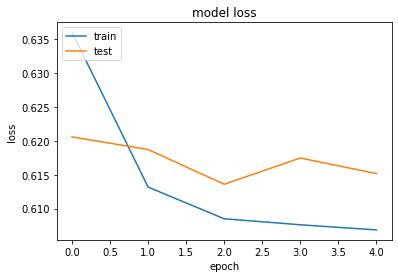

In [45]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

<p>Now we create a function called <code>showRecommendationsUser()</code> to show the top 10 movie recommendations for a given user. The input parameters are a recommender model and the specified <code>user_id</code> from the <code>df</code> Dataframe.</p>

In [46]:
def showRecommendationsUser(model, user_id= df.userId.sample(1).iloc[0]):
  movie_df = pd.read_csv(movielens_dir / "movies.csv")
# Let us get a user and see the top recommendations.
  movies_watched_by_user = df[df.userId == user_id]
  movies_not_watched = movie_df[
      ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
  ]["movieId"]
  movies_not_watched = list(
      set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
  )
  movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
  user_encoder = user2user_encoded.get(user_id)
  user_movie_array = np.hstack(
      ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
  )
  ratings = model.predict(user_movie_array).flatten()
  top_ratings_indices = ratings.argsort()[-10:][::-1]
  recommended_movie_ids = [
      movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
  ]
  print("Showing recommendations for user: {}".format(user_id))
  print("====" * 9)
  print("Movies with high ratings from user")
  print("----" * 8)
  top_movies_user = (
      movies_watched_by_user.sort_values(by="rating", ascending=False)
      .head(5)
      .movieId.values
  )
  movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
  for row in movie_df_rows.itertuples():
      print(row.title, ":", row.genres)
  print("----" * 8)
  print("Top 10 movie recommendations")
  print("----" * 8)
  recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
  for row in recommended_movies.itertuples():
      print(row.title, ":", row.genres)

<p>Using our function, we show the top 10 movie recommendations for <code>user_id</code> 420 generated by our first recommender model.</p>

In [47]:
showRecommendationsUser(model= first_model, user_id= 420)

Showing recommendations for user: 420
Movies with high ratings from user
--------------------------------
Singin' in the Rain (1952) : Comedy|Musical|Romance
Some Like It Hot (1959) : Comedy|Crime
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Rocky Horror Picture Show, The (1975) : Comedy|Horror|Musical|Sci-Fi
Super Size Me (2004) : Comedy|Documentary|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Rear Window (1954) : Mystery|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
Casablanca (1942) : Drama|Romance
Maltese Falcon, The (1941) : Film-Noir|Mystery
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Drama|Film-Noir|Romance
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
Memento (2000) : Mystery|Thriller


<h1>Experiment 2</h1>

<p>Now, inside of a function <code>showRecommendationsTJ()</code>, we create a feature vector for one member of our team, Timothy Jan. We pick some movies, assign a rating to each of them, and create a new Dataframe. It is then used to generate 10 movie recommendations using the recommender model passed by the input <code>model</code>.</p>

In [48]:
def showRecommendationsTJ(model):
  tj_movie_ID = [121231, 122900, 122902, 122904, 122906, 122912, 122916, 122918, 122920, 122922, 125916, 128360, 131739, 134130, 134853, 140715, 140956, 159858, 161354, 161594, 162082, 163645, 164367, 166024, 166528, 167370, 168248, 168252, 168366, 174053, 174055, 176101, 177285, 177593, 177763, 177765, 179401, 179819, 180031, 180985, 182715, 183635, 184471, 185029, 185135, 185585, 187031, 187593, 189713, 188189, ]
  tj_movie_ratings = [2.5, 3.5, 2.5, 3.75, 4.25, 4.25, 4.25, 3.5, 3.75, 3.25, 1.5, 4, 3.75, 4, 3.5, 3.75, 4, 3.75, 3.75, 4.25, 4.5, 4.25, 4.5, 4, 3.75, 0.5, 4.25, 3.5, 2, 4, 2.5, 3, 3.25, 4, 4, 3.5, 3, 3, 4.25, 3, 4, 2, 2.5, 4.5, 4.25, 4, 2.5, 3.5, 3.5, 4.5, ]
  tj_dict = {'movieId': tj_movie_ID, 'rating':tj_movie_ratings}
  movies_watched_by_tj = pd.DataFrame(tj_dict)
  movie_df = pd.read_csv(movielens_dir / "movies.csv")

  movies_not_watched_by_tj = movie_df[
      ~movie_df["movieId"].isin(movies_watched_by_tj.movieId.values)
  ]["movieId"]
  movies_not_watched_by_tj = list(
      set(movies_not_watched_by_tj).intersection(set(movie2movie_encoded.keys()))
  )
  movies_not_watched_by_tj = [[movie2movie_encoded.get(x)] for x in movies_not_watched_by_tj]
  user_encoder = 609 #must be in range, does not affect prediction. tested
  user_movie_array = np.hstack(
      ([[user_encoder]] * len(movies_not_watched_by_tj), movies_not_watched_by_tj)
  )
  ratings = model.predict(user_movie_array).flatten()
  top_ratings_indices = ratings.argsort()[-10:][::-1]
  recommended_movie_ids = [
      movie_encoded2movie.get(movies_not_watched_by_tj[x][0]) for x in top_ratings_indices
  ]
  print("Showing recommendations for user: TJ")
  print("====" * 9)
  print("Movies with high ratings from user")
  print("----" * 8)
  top_movies_user = (
      movies_watched_by_tj.sort_values(by="rating", ascending=False)
      .head(5)
      .movieId.values
  )
  movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
  for row in movie_df_rows.itertuples():
      print(row.title, ":", row.genres)
  print("----" * 8)
  print("Top 10 movie recommendations")
  print("----" * 8)
  recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
  for row in recommended_movies.itertuples():
      print(row.title, ":", row.genres)

<p>Using our function, we show the top 10 movie recommendations for our team member generated by our first recommender model.</p>

In [49]:
showRecommendationsTJ(first_model)

Showing recommendations for user: TJ
Movies with high ratings from user
--------------------------------
Kingsglaive: Final Fantasy XV (2016) : Action|Adventure|Animation|Drama|Fantasy|Sci-Fi
Train to Busan (2016) : Action|Thriller
The Girl with All the Gifts (2016) : Drama|Horror|Sci-Fi|Thriller
A Quiet Place (2018) : Drama|Horror|Thriller
Sorry to Bother You (2018) : Comedy|Fantasy|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
12 Angry Men (1957) : Drama
Lawrence of Arabia (1962) : Adventur

<p>The results showed good recommendations and were similar to the highest-rated movies for the user.</p>

<h1>Experiment 3</h1>

<p>To improve our results, we replaced the dot product with two hidden <code>Dense</code> layers in our recommender model. The first layer has 100 units, the second 50 units, and both are using the <code>relu</code> activation function.  We compiled the model using the <code>BinaryCrossentropy</code> loss function and the <code>Adam</code> optimizer with a learning rate of 0.001.</p>





In [50]:
EMBEDDING_SIZE = 50

class improvedRecommender(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(improvedRecommender, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.user_movie_relationship1 = tf.keras.layers.Dense(100, activation= "relu")# use_bias= False)#, input_shape = (64,)
        self.user_movie_relationship2 = tf.keras.layers.Dense(50, activation= "relu")# use_bias= False)#, input_shape = (64,)
        self.output_layer = tf.keras.layers.Dense(1, activation= "sigmoid", input_shape= (50,))#, use_biase=False)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        
        concat_inputs = tf.concat([user_vector, movie_vector], 1)
        concat_bias = user_bias + movie_bias
        response = self.user_movie_relationship1(concat_inputs)
        response = self.user_movie_relationship2(response)
        response = response + concat_bias
        response = self.output_layer(response)
        return response


new_model = improvedRecommender(num_users, num_movies, EMBEDDING_SIZE)
new_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<p>We fit the new model to our dataset. We used a batch size of 64, 5 epochs, and a verbosity of 1. After training, we achieve a <code>loss</code> of 0.5600 and a <code>val_loss</code> of 0.6109, which is an improvement over our first model.</p>

In [51]:
history = new_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.6051 - val_loss: 0.6015
Epoch 2/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.5900 - val_loss: 0.6007
Epoch 3/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.5813 - val_loss: 0.6028
Epoch 4/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.5708 - val_loss: 0.6088
Epoch 5/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.5610 - val_loss: 0.6130


<h1>Experiment 4</h1>

<p>Now we call our functions using our new recommender model and the same users.</p>

In [52]:
showRecommendationsUser(model= new_model, user_id= 420)

Showing recommendations for user: 420
Movies with high ratings from user
--------------------------------
Singin' in the Rain (1952) : Comedy|Musical|Romance
Some Like It Hot (1959) : Comedy|Crime
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Rocky Horror Picture Show, The (1975) : Comedy|Horror|Musical|Sci-Fi
Super Size Me (2004) : Comedy|Documentary|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Casablanca (1942) : Drama|Romance
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Drama|Film-Noir|Romance
Man for All Seasons, A (1966) : Drama
Doctor Zhivago (1965) : Drama|Romance|War
Lifeboat (1944) : Drama|War
Yojimbo (1961) : Action|Adventure
Man Bites Dog (C'est arrivé près de chez vous) (1992) : Comedy|Crime|Drama|Thriller
Guess Who's Coming to Dinner (1967) : Drama
Trial, The (Procès, Le) (1962) : Drama
Infernal Affairs (Mou gaan dou) (2002) : Crime|Drama|Thriller


In [53]:
showRecommendationsTJ(new_model)

Showing recommendations for user: TJ
Movies with high ratings from user
--------------------------------
Kingsglaive: Final Fantasy XV (2016) : Action|Adventure|Animation|Drama|Fantasy|Sci-Fi
Train to Busan (2016) : Action|Thriller
The Girl with All the Gifts (2016) : Drama|Horror|Sci-Fi|Thriller
A Quiet Place (2018) : Drama|Horror|Thriller
Sorry to Bother You (2018) : Comedy|Fantasy|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Godfather, The (1972) : Crime|Drama
Paths of Glory (1957) : Drama|War
Apocalypse Now (1979) : Action|Drama|War
Touch of Evil (1958) : Crime|Film-Noir|Thriller
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Jules and Jim (Jules et Jim) (1961) : Drama|Romance
Man Bites Dog (C'est arrivé près de chez vous) (1992) : Comedy|Crime|Drama|Thriller
Rififi (Du rififi chez les hommes) (1955) : Crime|Film-Noir|Thriller
Dog Soldiers (2002) : Action|Horror
Trial, The (Procès, Le) (1962) : Drama


For the purpose of estimating the quality of the recommendations, Tim excluded some of his favorite movies from his feature vector.

A handful of Tim's favorite movies that he neglected to add/rate are consistently in the top 5 recommendations. However, the overall quality of the recommendations are worse.  The previous model consistently recommended atleast 8 movies Tim enjoys.

<h1>Experiment 5</h1>


<p>To improve our results farther, we added a custom <code>Sampling</code> layer in our model. After encoding our inputs in the <code>Embedding</code> layers, we invoke the <code>Sampling</code> layer. We removed the first hidden <code>Dense</code> layer with 100 units (using both layers was causing <b>mode collapse</b>) and only kept the second <code>Dense</code> with 50 units,  using the <code>relu</code> activation function.  We compiled the model using the <code>BinaryCrossentropy</code> loss function and the <code>Adam</code> optimizer with a learning rate of 0.001.</p>

In [54]:
EMBEDDING_SIZE = 50

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding the embedded user-movie inputs."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class improvedRecommenderWithAutoEncoder(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(improvedRecommenderWithAutoEncoder, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.user_movie_relationship1 = tf.keras.layers.Dense(50, activation= "relu")
        #self.user_movie_relationship2 = tf.keras.layers.Dense(50, activation= "relu")
        self.output_layer = tf.keras.layers.Dense(1, activation= "sigmoid", input_shape= (50,))

        self.DenseSamplerZmean = tf.keras.layers.Dense(10, name="z_mean")
        self.DenseSamplerZlogvar = tf.keras.layers.Dense(10, name="z_log_var")
        self.Sampling = Sampling()

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        
        concat_inputs = tf.concat([user_vector, movie_vector], 1)
        concat_bias = user_bias + movie_bias
        
        z_mean = self.DenseSamplerZmean(concat_inputs)
        z_log_var = self.DenseSamplerZlogvar(concat_inputs)
        response = self.Sampling([z_mean, z_log_var])

        #response = self.user_movie_relationship1(concat_inputs)
        response = self.user_movie_relationship1(response)
        #response = self.user_movie_relationship2(response)
        response = response + concat_bias
        response = self.output_layer(response)
        return response
    

final_model = improvedRecommenderWithAutoEncoder(num_users, num_movies, EMBEDDING_SIZE)
final_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [55]:
history = final_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6141 - val_loss: 0.6061
Epoch 2/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.5967 - val_loss: 0.6033
Epoch 3/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.5925 - val_loss: 0.6022
Epoch 4/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.5896 - val_loss: 0.6016
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.5870 - val_loss: 0.6028


In [56]:
showRecommendationsUser(model= final_model, user_id= 420)

Showing recommendations for user: 420
Movies with high ratings from user
--------------------------------
Singin' in the Rain (1952) : Comedy|Musical|Romance
Some Like It Hot (1959) : Comedy|Crime
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Rocky Horror Picture Show, The (1975) : Comedy|Horror|Musical|Sci-Fi
Super Size Me (2004) : Comedy|Documentary|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Kolya (Kolja) (1996) : Comedy|Drama
Lifeboat (1944) : Drama|War
Yojimbo (1961) : Action|Adventure
Five Easy Pieces (1970) : Drama
Woman in the Dunes (Suna no onna) (1964) : Drama
Trial, The (Procès, Le) (1962) : Drama
Memories of Murder (Salinui chueok) (2003) : Crime|Drama|Mystery|Thriller
Wild Parrots of Telegraph Hill, The (2003) : Documentary
Band of Brothers (2001) : Action|Drama|War
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama


In [57]:
showRecommendationsTJ(final_model)

Showing recommendations for user: TJ
Movies with high ratings from user
--------------------------------
Kingsglaive: Final Fantasy XV (2016) : Action|Adventure|Animation|Drama|Fantasy|Sci-Fi
Train to Busan (2016) : Action|Thriller
The Girl with All the Gifts (2016) : Drama|Horror|Sci-Fi|Thriller
A Quiet Place (2018) : Drama|Horror|Thriller
Sorry to Bother You (2018) : Comedy|Fantasy|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Secrets & Lies (1996) : Drama
Cinema Paradiso (Nuovo cinema Paradiso) (1989) : Drama
Yojimbo (1961) : Action|Adventure
Woman in the Dunes (Suna no onna) (1964) : Drama
Guess Who's Coming to Dinner (1967) : Drama
Adam's Rib (1949) : Comedy|Romance
Day of the Doctor, The (2013) : Adventure|Drama|Sci-Fi
Captain Fantastic (2016) : Drama
Band of Brothers (2001) : Action|Drama|War


The top 5 recommendations will usually have one of the movies Tim really likes that he purposefully neglected to add/rate. These correctly recommended movies include The Shawshank Redemption, Pulp Fiction, The Godfather, Star Wars, and A Clockwork Orange.

Tim hasn't seen most of the other recommendations though, but judging by their IMDB pages and movie category, these are good recommendations.

Overall, this model is outperforming the previous model.  The quality of these recommendations is on par with the original model's recommendations.
